In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

!pip install optuna
!pip install timm
!pip install scikit-learn
!pip install pandas
!pip install seaborn

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 13.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes

In [2]:
# Continue with regular imports
!pip install matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[INFO] Couldn't find torchinfo... installing it.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.4 MB/s eta 0:00:00
time: 618 µs (started: 2023-04-16 15:01:33 +00:00)


In [3]:
#download a kaggle dataset that is already split into training, validation and test dataset
#with a ratio for 80/10/10 
#upload a kaggle.json file before running this code. The json file can be obtained through your account settings in kaggle
!pip install -q kaggle
!apt-get install -y unzip
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d bhanuprasanna/isic-2019
!unzip /isic-2019.zip #change this code to the correct path name to unzip the dataset

Streaminguitvoer ingekort tot de laatste 5000 regels.
  inflating: ISIC - 2019/train/Melanoma/ISIC_0053916.jpg  
  inflating: ISIC - 2019/train/Melanoma/ISIC_0053933.jpg  
  inflating: ISIC - 2019/train/Melanoma/ISIC_0053945.jpg  
  inflating: ISIC - 2019/train/Melanoma/ISIC_0053947.jpg  
  inflating: ISIC - 2019/train/Melanoma/ISIC_0053953.jpg  
  inflating: ISIC - 2019/train/Melanoma/ISIC_0053960.jpg  
  inflating: ISIC - 2019/train/Melanoma/ISIC_0053971.jpg  
  inflating: ISIC - 2019/train/Melanoma/ISIC_0053973.jpg  
  inflating: ISIC - 2019/train/Melanoma/ISIC_0053985.jpg  
  inflating: ISIC - 2019/train/Melanoma/ISIC_0054006.jpg  
  inflating: ISIC - 2019/train/Melanoma/ISIC_0054021.jpg  
  inflating: ISIC - 2019/train/Melanoma/ISIC_0054024.jpg  
  inflating: ISIC - 2019/train/Melanoma/ISIC_0054025.jpg  
  inflating: ISIC - 2019/train/Melanoma/ISIC_0054053.jpg  
  inflating: ISIC - 2019/train/Melanoma/ISIC_0054061.jpg  
  inflating: ISIC - 2019/train/Melanoma/ISIC_0054062.jpg  
  

In [4]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Get a set of pretrained model weights
weights = torchvision.models.MaxVit_T_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

# Set the random seed for reproducibility
torch.manual_seed(42)

# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[224]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

time: 6.44 ms (started: 2023-04-16 15:10:33 +00:00)


In [5]:
from torchvision.transforms import Compose, CenterCrop, Normalize, Resize, ToTensor
from torchvision.transforms import InterpolationMode
from torchvision.transforms import RandAugment

# Define the transformation parameters
resize_size = [224, 224]
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
interpolation = InterpolationMode.BICUBIC

# Define the randaugment transformation pipeline for the training set
randaug_transform = Compose([
    RandAugment(num_ops=3, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None),
    Resize(resize_size, interpolation=interpolation),
    ToTensor(),
    Normalize(mean=mean, std=std)
])

time: 932 µs (started: 2023-04-16 15:10:33 +00:00)


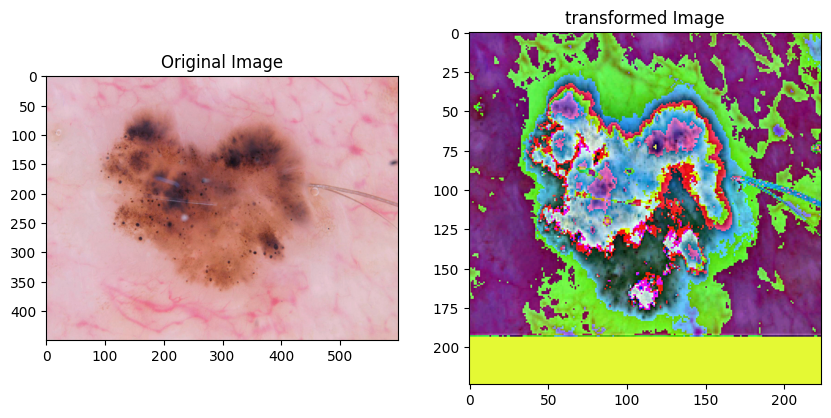

time: 544 ms (started: 2023-04-16 15:10:39 +00:00)


In [7]:
#show the image after applying transform, the picture looks distorted because we have applied normalization 
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the input image
image_path = '/content/ISIC - 2019/test/Basal cell carcinoma/ISIC_0027229.jpg'
input_image = Image.open(image_path)

# Apply the transforms function to the input image
auto_transformsimg = randaug_transform(input_image)

# Convert the tensor back to an image for visualization
auto_transformsimg = transforms.ToPILImage()(auto_transformsimg)

# Display the original and transformed images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(input_image)
axs[0].set_title('Original Image')
axs[1].imshow(auto_transformsimg)
axs[1].set_title('transformed Image')
plt.show()

In [8]:
from torchvision import datasets, transforms
import torch.utils.data as data
from torch.utils.data import Subset

# Set the random seed for reproducibility
torch.manual_seed(42)

# Load and transform the data
train_dataset = datasets.ImageFolder(root='/content/ISIC - 2019/train', transform=randaug_transform)
test_dataset = datasets.ImageFolder(root='/content/ISIC - 2019/test', transform=auto_transforms)
val_dataset = datasets.ImageFolder(root='/content/ISIC - 2019/val', transform=auto_transforms)

# load the data and shuffle the training data
train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_dataloader = data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

time: 78.7 ms (started: 2023-04-16 15:10:51 +00:00)


In [9]:
import timm 
#look up all the maxvit models in timm's library
repvgg_models = timm.list_models('*repvgg*')
repvgg_models

['repvgg_a2',
 'repvgg_b0',
 'repvgg_b1',
 'repvgg_b1g4',
 'repvgg_b2',
 'repvgg_b2g4',
 'repvgg_b3',
 'repvgg_b3g4']

time: 237 ms (started: 2023-04-16 15:10:54 +00:00)


In [10]:
import timm 
import torch

#create the model and change number of classes to 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = timm.create_model('repvgg_b3', pretrained=True, num_classes=8)
model.to(device)

# Set the random seed for reproducibility
torch.manual_seed(42)

#freeze the weights
for param in model.parameters():
    param.requires_grad = False
   
# unfreeze the last fc layer
for param in model.head.parameters():
    param.requires_grad = True
    
# Add a dropout layer to the fc sequential block in the ClassifierHead
model.head.fc = nn.Sequential(
nn.Dropout(p=0.5),
nn.Linear(model.head.fc.in_features, model.head.fc.out_features)
)



Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-repvgg-weights/repvgg_b3-199bc50d.pth" to /root/.cache/torch/hub/checkpoints/repvgg_b3-199bc50d.pth


time: 30.6 s (started: 2023-04-16 15:10:54 +00:00)


In [11]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ByobNet (ByobNet)                                  [32, 3, 224, 224]    [32, 8]              --                   Partial
├─RepVggBlock (stem)                               [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    └─ConvNormAct (conv_1x1)                      [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    │    └─Conv2d (conv)                          [32, 3, 224, 224]    [32, 64, 112, 112]   (192)                False
│    │    └─BatchNormAct2d (bn)                    [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ConvNormAct (conv_kxk)                      [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    │    └─Conv2d (conv)                          [32, 3, 224, 224]    [32, 64, 112, 112]   (1,728)              False
│    │    └─BatchNormAct2d (bn)   

time: 6.24 s (started: 2023-04-16 15:11:25 +00:00)


In [12]:
# Setup device agnostic code

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0015992901782311139, weight_decay=8.002308769716137e-10)


time: 1.63 ms (started: 2023-04-16 15:11:31 +00:00)


In [13]:
import matplotlib.pyplot as plt

# Lists to store the loss and accuracy values
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Train the model
num_epochs = 20
best_val_loss = float('inf')
patience = 5
for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for data in train_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        train_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

    # Evaluate the model
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for data in valid_dataloader:
            inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

    # Print the results for this epoch
    train_loss /= len(train_dataloader.dataset)
    train_acc /= len(train_dataloader.dataset)
    val_loss /= len(valid_dataloader.dataset)
    val_acc /= len(valid_dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save the loss and accuracy values
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Check if the current validation loss is the best seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    # Stop training if the validation loss has not improved for `patience` epochs
    if epochs_since_improvement == patience:
        print(f"No improvement for {patience} epochs, stopping training.")
        break

Epoch 1/20: Train Loss: 1.2690, Train Acc: 0.5673, Val Loss: 1.1603, Val Acc: 0.6084
Epoch 2/20: Train Loss: 1.1357, Train Acc: 0.6063, Val Loss: 1.0976, Val Acc: 0.6178
Epoch 3/20: Train Loss: 1.0960, Train Acc: 0.6145, Val Loss: 1.0685, Val Acc: 0.6262
Epoch 4/20: Train Loss: 1.0734, Train Acc: 0.6215, Val Loss: 1.0486, Val Acc: 0.6199
Epoch 5/20: Train Loss: 1.0616, Train Acc: 0.6268, Val Loss: 1.0310, Val Acc: 0.6257
Epoch 6/20: Train Loss: 1.0423, Train Acc: 0.6338, Val Loss: 1.0085, Val Acc: 0.6393
Epoch 7/20: Train Loss: 1.0342, Train Acc: 0.6333, Val Loss: 1.0070, Val Acc: 0.6445
Epoch 8/20: Train Loss: 1.0274, Train Acc: 0.6355, Val Loss: 0.9929, Val Acc: 0.6377
Epoch 9/20: Train Loss: 1.0273, Train Acc: 0.6344, Val Loss: 0.9863, Val Acc: 0.6398
Epoch 10/20: Train Loss: 1.0169, Train Acc: 0.6334, Val Loss: 0.9798, Val Acc: 0.6419
Epoch 11/20: Train Loss: 1.0099, Train Acc: 0.6367, Val Loss: 0.9688, Val Acc: 0.6461
Epoch 12/20: Train Loss: 1.0044, Train Acc: 0.6413, Val Loss: 0

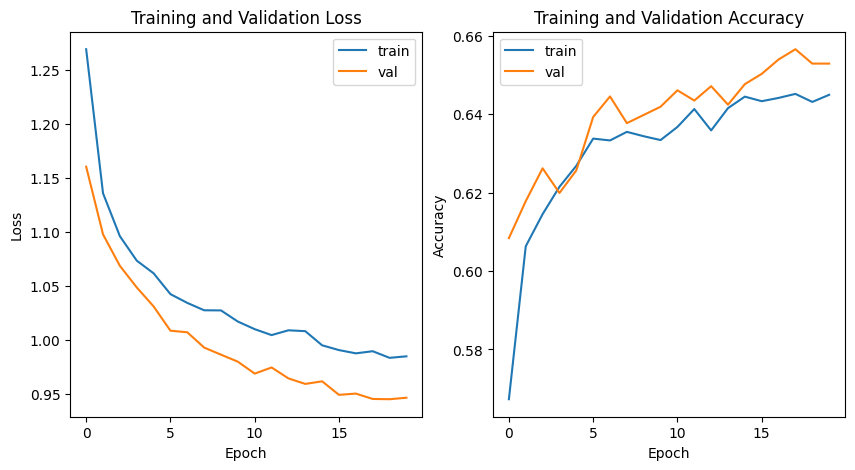

time: 382 ms (started: 2023-04-16 17:39:23 +00:00)


In [14]:
# Plot the validation and training loss and accuracy values
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(val_losses, label='val')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()
ax[1].plot(train_accs, label='train')
ax[1].plot(val_accs, label='val')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].legend()
plt.show()

In [15]:
#evaluate on test set and calculate metrics, we are calculating macro f1 and roc-auc score, because of the heavily imbalanced dataset

from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, classification_report
import pandas as pd
import numpy as np

model.eval()
test_loss = 0.0
test_acc = 0.0
y_true = []
y_scores = []
y_pred = []

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        test_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

        # Append predictions to lists
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

test_loss /= len(test_dataloader.dataset)
test_acc /= len(test_dataloader.dataset)

# Calculate metrics

import warnings
from sklearn.exceptions import UndefinedMetricWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(8)], digits=4)

conf_mat = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(np.array(pd.get_dummies(y_true)), y_scores, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Calculate other metrices
n_classes = conf_mat.shape[0]
sensitivity = 0
specificity = 0
for i in range(n_classes):
    tp = conf_mat[i,i]
    fn = np.sum(conf_mat[i,:]) - tp
    fp = np.sum(conf_mat[:,i]) - tp
    tn = np.sum(conf_mat) - tp - fn - fp
    sensitivity += tp / (tp + fn) * np.sum(conf_mat[i,:])
    specificity += tn / (tn + fp) * np.sum(conf_mat[i,:])
sensitivity /= np.sum(conf_mat)
specificity /= np.sum(conf_mat)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(report)

Test Loss: 0.9219
Test Accuracy: 0.6601
Sensitivity: 0.6601
Specificity: 0.8446
ROC-AUC: 0.8570
F1-score: 0.3542
Classification Report:
              precision    recall  f1-score   support

           0     0.3784    0.1867    0.2500        75
           1     0.4872    0.7640    0.5950       250
           2     0.5618    0.2463    0.3425       203
           3     0.0000    0.0000    0.0000        11
           4     0.7840    0.8539    0.8175       965
           5     0.5382    0.5278    0.5330       360
           6     0.6667    0.0476    0.0889        42
           7     0.6000    0.1250    0.2069        24

    accuracy                         0.6601      1930
   macro avg     0.5020    0.3439    0.3542      1930
weighted avg     0.6513    0.6601    0.6355      1930

time: 51.8 s (started: 2023-04-16 17:39:24 +00:00)


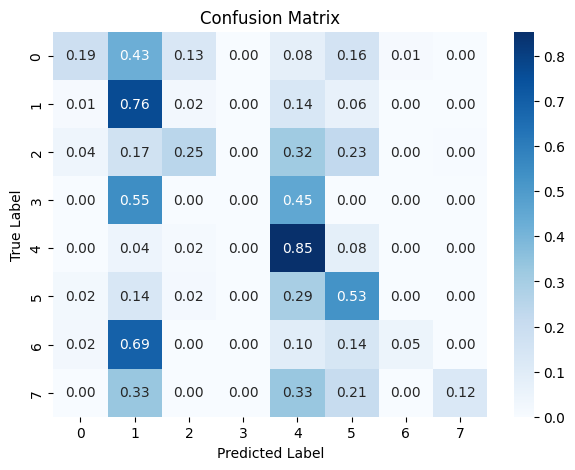

time: 419 ms (started: 2023-04-16 17:40:16 +00:00)


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(conf_mat / conf_mat.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels([str(i) for i in range(8)])
ax.yaxis.set_ticklabels([str(i) for i in range(8)])
plt.show()